In [76]:
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import scipy.ndimage as ndimage


In [77]:
# This notebook measures the spectral lines of a He lamp using the calibration data from the Hg lamp

In [31]:
# Set the horizontal limits of the spectrum image
low_limit = 250
up_limit = 750


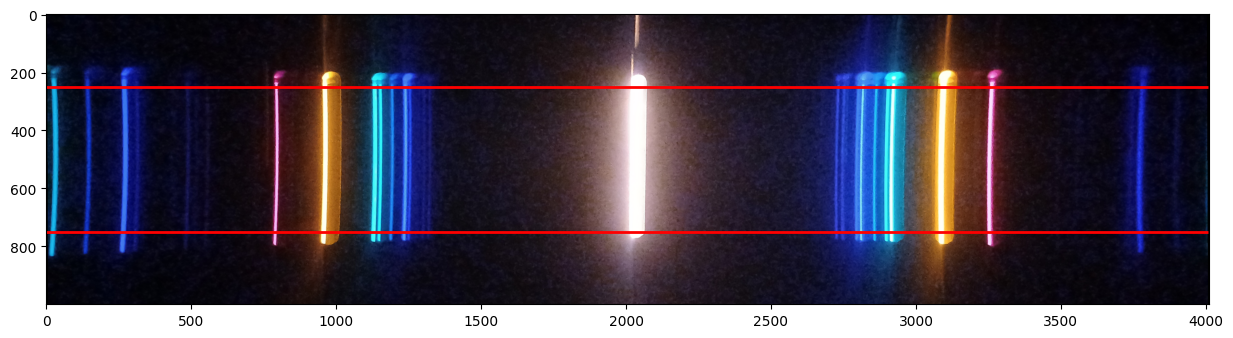

In [32]:
# Plot the spectrum image with the horizontal limits

img = image.imread('lamps_new/2.jpg')
img = ndimage.rotate(img, +0.2)
img = img[1000:2000, :, :]

plt.figure(figsize = (15, 7))
plt.imshow(img)
plt.hlines(y=[low_limit, up_limit], xmin=0,
           xmax=img.shape[1]-1, colors='red', linewidth=2)
plt.show()


In [33]:
from scipy.signal import savgol_filter
from BaselineRemoval import BaselineRemoval

signal = np.linalg.norm(np.sum(img[low_limit:up_limit, :, :], axis=0), axis=1)
signal /= np.max(signal)

signal = savgol_filter(signal, 14, 7)
 
baseObj = BaselineRemoval(signal)
signal = baseObj.ZhangFit()

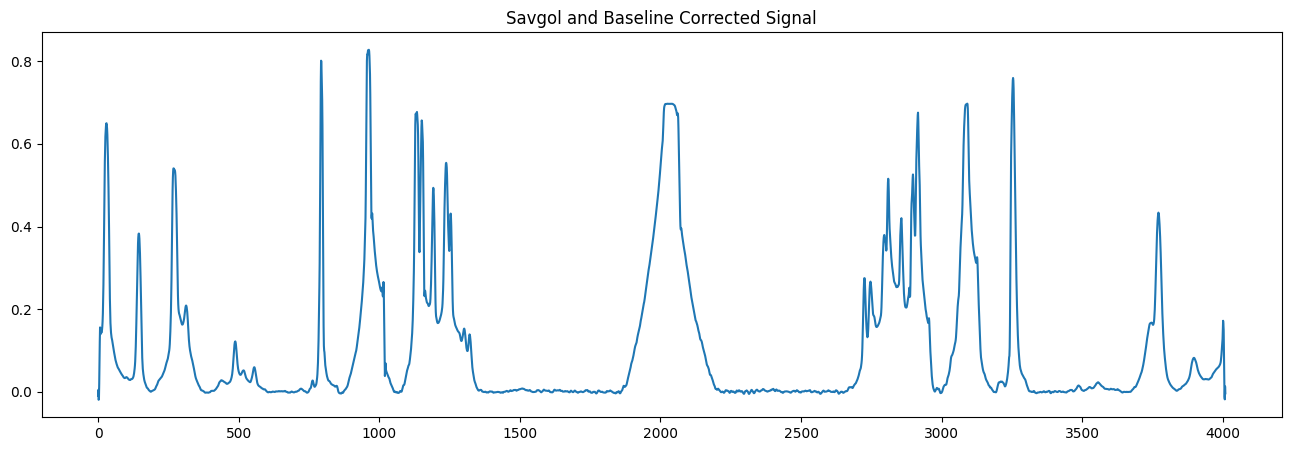

In [34]:
plt.figure(figsize = (16, 5))
plt.title("Savgol and Baseline Corrected Signal")
plt.plot(signal)

In [35]:
# Set the limits for the first order spectrum and the peakpicking threshold
small_limit = 550
large_limit = 3500
thr = 0.1
peaks, _ = find_peaks(signal, height=thr, prominence=0.05)

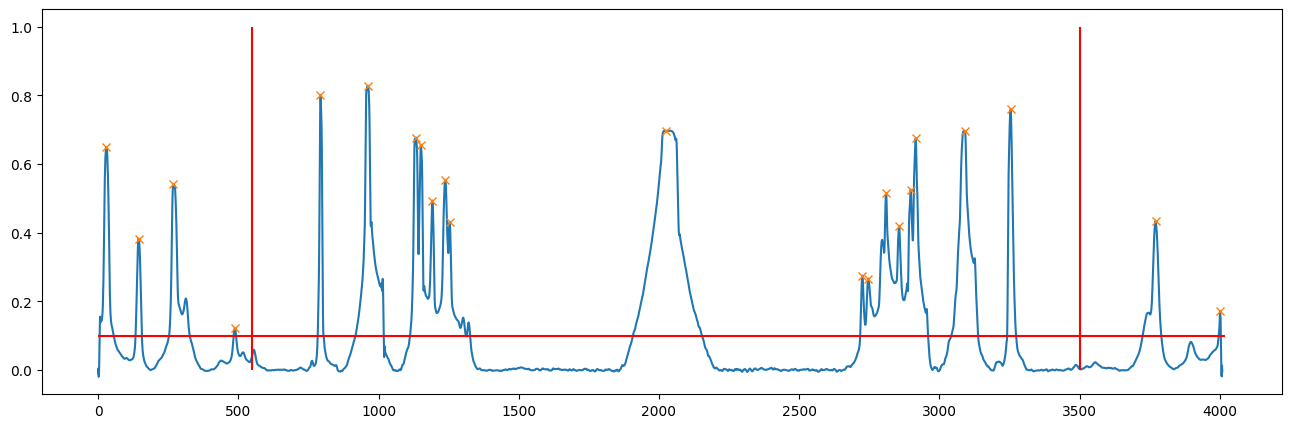

In [36]:
fig, ax = plt.subplots(figsize = (16, 5))

ax.plot(signal)
ax.plot(peaks, signal[peaks], "x")

ax.vlines(small_limit, 0, 1, "r")
ax.vlines(large_limit, 0, 1, "r")
ax.hlines(thr, 0, 4020, "r")


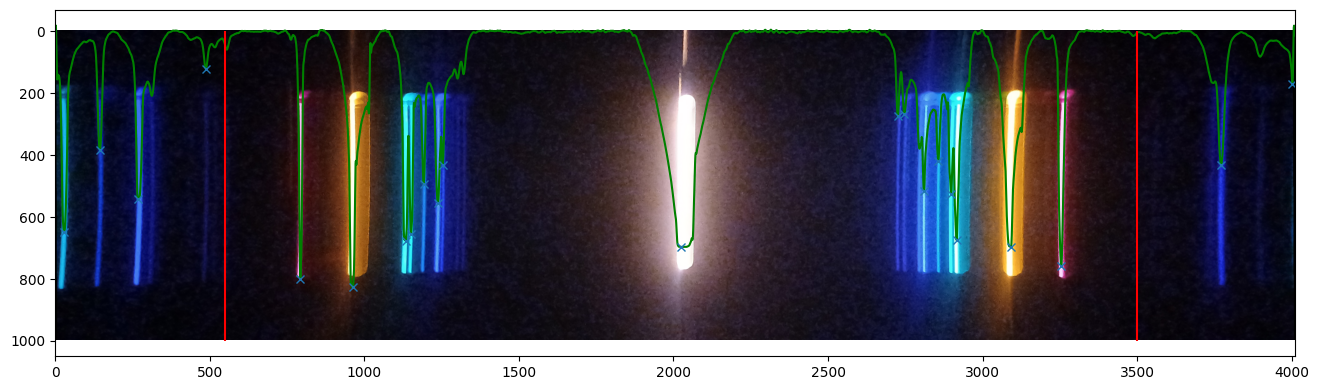

In [37]:
# Plot the spectrum and the image superimposed
fig, ax = plt.subplots(figsize = (16, 5))

ax.imshow(img)

ax.plot(1000*signal, "g")
ax.plot(peaks, 1000*signal[peaks], "x")

ax.vlines(small_limit, 0, 1000, "r")
ax.vlines(large_limit, 0, 1000, "r")


In [38]:
# Get the peaks inside the limits
good_peaks = np.array(
    [peak for peak in peaks if small_limit <= peak <= large_limit])
good_peaks


array([ 793,  963, 1134, 1151, 1192, 1238, 1254, 2024, 2725, 2747, 2810,
       2857, 2898, 2916, 3091, 3254])

In [39]:
mid_value = 2000
mid_peak = min(good_peaks, key=lambda x: abs(x - mid_value))
distances = np.abs(good_peaks-mid_peak)
mid_index = np.argmin(distances)
distances


array([1231, 1061,  890,  873,  832,  786,  770,    0,  701,  723,  786,
        833,  874,  892, 1067, 1230])

In [40]:
right_distances = distances[mid_index+1:]
right_distances


array([ 701,  723,  786,  833,  874,  892, 1067, 1230])

In [41]:
left_distances = distances[:mid_index][::-1]
left_distances


array([ 770,  786,  832,  873,  890, 1061, 1231])

In [42]:
mean_distances = []
i = 0
j = 0
thr = 10

while i < len(right_distances) and j < len(left_distances):
    if np.abs(right_distances[i]-left_distances[j]) < thr:
        mean_distances.append(0.5*(right_distances[i]+left_distances[j]))
        i += 1
        j += 1
    elif right_distances[i] < left_distances[j]:
        mean_distances.append(right_distances[i])
        i += 1
    else:
        mean_distances.append(left_distances[j])
        j += 1

if i < len(right_distances):
    mean_distances += list(right_distances[i:])
else:
    mean_distances += list(left_distances[i:])

mean_distances = np.array(mean_distances)


In [43]:
mean_distances


array([ 701. ,  723. ,  770. ,  786. ,  832.5,  873.5,  891. , 1064. ,
       1230.5])

In [94]:
# Compute the wavelengths using the calibrated grating constant and focal length

In [78]:
d = 1.6811262998600208e-06
D = 2850.1717788971596


In [88]:
lambdas = d * ((D/mean_distances)**2+1)**(-0.5)
lambdas *= 1e9
lambdas


array([401.5075719 , 413.35747525, 438.45296419, 446.92586829,
       471.34142045, 492.60445268, 501.60273107, 587.94982333,
       666.34217111])

In [89]:
measured_lambdas = np.array([401.5075719, 446.92586829, 471.34142045,492.60445268, 501.60273107, 587.94982333, 666.34217111])
good_lambdas = np.array([402.6, 447.1, 471.3, 492.1, 501.5, 587.5, 667.8])
np.abs(measured_lambdas - good_lambdas)

array([1.0924281 , 0.17413171, 0.04142045, 0.50445268, 0.10273107,
       0.44982333, 1.45782889])

In [90]:
np.mean(np.abs(measured_lambdas - good_lambdas)*10)

5.461166042857063

In [95]:
# Compute the wavelengths using the calibrated 2nd order polynomial model

In [96]:
poly = np.poly1d([-7.48542813e-14,  6.45966427e-10, -1.45577201e-08])

In [97]:
poly(mean_distances)*1e9

array([401.48127654, 413.34750301, 438.45532531, 446.92721595,
       471.33110288, 492.57996883, 501.57297466, 588.00832579,
       666.96483667])

In [98]:
measured_lambdas = np.array([401.48127654, 446.92721595, 471.33110288,492.57996883, 501.57297466, 588.00832579, 666.96483667])
good_lambdas = np.array([402.6, 447.1, 471.3, 492.1, 501.5, 587.5, 667.8])
np.mean(np.abs(measured_lambdas - good_lambdas)*10)

4.598632857142775